In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Jul 25 15:45:54 2023

@author: gurasog
"""

# docs and experiment results can be found at https://docs.cleanrl.dev/rl-algorithms/dqn/#dqnpy
import argparse
import os
import random
import time
from distutils.util import strtobool

import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from stable_baselines3.common.buffers import ReplayBuffer
from torch.utils.tensorboard import SummaryWriter





pygame 2.1.3 (SDL 2.0.22, Python 3.7.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


### Utils functions

In [8]:

def onehot(idx, dim):
    vec = np.zeros(dim)
    #print('idx',idx)
    vec[int(idx)] = 1
    return torch.tensor(vec)

def recode_state(state):
    #print('recode_state state', state)
    #state=state.detach()
    taxi_row, taxi_col, pass_loc, dest_idx = decode(state)

    #print(taxi_row, taxi_col, pass_loc, dest_idx)
    oh_taxi_x = onehot(taxi_row, 5)
    oh_taxi_y = onehot(taxi_col, 5)
    oh_pass_loc = onehot(pass_loc, 5)
    oh_dest_loc = onehot(dest_idx, 4)
    oh_all = torch.cat([oh_taxi_x, oh_taxi_y, oh_pass_loc, oh_dest_loc], 0)
    #print('state after', torch.Tensor(oh_all) )
    return torch.tensor(oh_all,dtype=torch.float32)

def decode(i):
        out = []
        out.append(i % 4)
        i = i // 4
        out.append(i % 5)
        i = i // 5
        out.append(i % 5)
        i = i // 5
        out.append(i)
        assert 0 <= i < 5
        state_extended = []
        for i in reversed(out):
            state_extended.append(i)
        return state_extended

def recode_states(states):
    recoded_states=[recode_state(states[i]).detach().numpy() for i in range(len(states))]
    recoded_states=to_tensor(np.array(recoded_states))
    return recoded_states



def to_tensor(x, dtype=np.float32):
    if isinstance(x, torch.Tensor):
        return x

    x=np.asarray(x, dtype=dtype)
    x=torch.from_numpy(x)
    return x




def make_env(env_id, seed, idx, capture_video, run_name):
    def thunk():
        if capture_video and idx == 0:
            env = gym.make(env_id, render_mode="rgb_array")
            env = gym.wrappers.RecordVideo(env, f"videos/{run_name}")
        else:
            env = gym.make(env_id)
        env = gym.wrappers.RecordEpisodeStatistics(env)
        env.action_space.seed(seed)

        return env

    return thunk


def linear_schedule(start_e: float, end_e: float, duration: int, t: int):
    slope = (end_e - start_e) / duration
    return max(slope * t + start_e, end_e)

### Parameters and Hyperparameters

In [11]:
def parse_args():
    
    class Args:
        
        def __init__(self):
            pass
        
    args_dict = dict(batch_size=128,
              buffer_size=1000000,
              capture_video=False,
              cuda=True, end_e=0.01,
              env_id='Taxi-v3',
              exp_name='DQN',
              exploration_fraction=0.1,
              gamma=0.99, hf_entity='',
              learning_rate=0.0001,
              learning_starts=80000,
              num_envs=1,
              save_model=True,
              seed=1,
              start_e=1,
              target_network_frequency=1000,
              tau=1.0,
              torch_deterministic=True,
              total_timesteps=6000000,
              track=False, train_frequency=4,
              upload_model=False,
              wandb_entity=None, 
              wandb_project_name='cleanRL')
    args = Args()
    args.__dict__ = args_dict
    
    return args

### Network

In [12]:
# ALGO LOGIC: initialize agent here:
class QNetwork(nn.Module):
    def __init__(self, env):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(np.array([19]).prod(), 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, env.single_action_space.n),
        )

    def forward(self, x):
        return self.network(x)



### Main

In [13]:

if __name__ == "__main__":
    import stable_baselines3 as sb3

    if sb3.__version__ < "2.0":
        raise ValueError(
            """Ongoing migration: run the following command to install the new dependencies:

poetry run pip install "stable_baselines3==2.0.0a1"
"""
        )
    args = parse_args()
    run_name = f"{args.env_id}__{args.exp_name}__{args.seed}__{int(time.time())}"
    if args.track:
        import wandb

        wandb.init(
            project=args.wandb_project_name,
            entity=args.wandb_entity,
            sync_tensorboard=True,
            config=vars(args),
            name=run_name,
            monitor_gym=True,
            save_code=True,
        )
    writer = SummaryWriter(f"runs/baseline_DQN_{run_name}")
    writer.add_text(
        "hyperparameters",
        "|param|value|\n|-|-|\n%s" % ("\n".join([f"|{key}|{value}|" for key, value in vars(args).items()])),
    )

    # TRY NOT TO MODIFY: seeding
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    torch.backends.cudnn.deterministic = args.torch_deterministic

    device = torch.device("cuda" if torch.cuda.is_available() and args.cuda else "cpu")

    # env setup
    envs = gym.vector.SyncVectorEnv(
        [make_env(args.env_id, args.seed + i, i, args.capture_video, run_name) for i in range(args.num_envs)]
    )
    assert isinstance(envs.single_action_space, gym.spaces.Discrete), "only discrete action space is supported"

    q_network = QNetwork(envs).to(device)
    optimizer = optim.Adam(q_network.parameters(), lr=args.learning_rate)
    target_network = QNetwork(envs).to(device)
    target_network.load_state_dict(q_network.state_dict())

    rb = ReplayBuffer(
        args.buffer_size,
        envs.single_observation_space,
        envs.single_action_space,
        device,
        handle_timeout_termination=False,
    )
    start_time = time.time()

    # TRY NOT TO MODIFY: start the game
    obs, _ = envs.reset(seed=args.seed)
    for global_step in range(args.total_timesteps):
        # ALGO LOGIC: put action logic here
        epsilon = linear_schedule(args.start_e, args.end_e, args.exploration_fraction * args.total_timesteps, global_step)
        if random.random() < epsilon:
            actions = np.array([envs.single_action_space.sample() for _ in range(envs.num_envs)])
        else:
            encoded_obs=recode_states(obs)
            q_values = q_network(torch.Tensor(encoded_obs).to(device))
            actions = torch.argmax(q_values).cpu().numpy()
            actions= np.array([actions])
            
        
                '''Adding observation in a dictionary to simplify the further computation'''
        if obs[0] in dict_of_observations:
            pass
        else:
            image=get_image(envs)
            dict_of_observations[obs[0]]=image
                
                
        # TRY NOT TO MODIFY: execute the game and log data.
        next_obs, rewards, terminated, truncated, infos = envs.step(actions)

        # TRY NOT TO MODIFY: record rewards for plotting purposes
        if "final_info" in infos:
            for info in infos["final_info"]:
                # Skip the envs that are not done
                if "episode" not in info:
                    continue
                print(f"global_step={global_step}, episodic_return={info['episode']['r']}")
                writer.add_scalar("charts/episodic_return", info["episode"]["r"], global_step)
                writer.add_scalar("charts/episodic_length", info["episode"]["l"], global_step)
                writer.add_scalar("charts/epsilon", epsilon, global_step)

        # TRY NOT TO MODIFY: save data to reply buffer; handle `final_observation`
        real_next_obs = next_obs.copy()
        for idx, d in enumerate(truncated):
            if d:
                real_next_obs[idx] = infos["final_observation"][idx]
        
        rb.add(obs, real_next_obs, actions, rewards, terminated, infos)

        # TRY NOT TO MODIFY: CRUCIAL step easy to overlook
        obs = next_obs

        # ALGO LOGIC: training.
        if global_step > args.learning_starts:
            if global_step % args.train_frequency == 0:
                data = rb.sample(args.batch_size)
                with torch.no_grad():
                    encoded_next_obs=recode_states(data.next_observations)
                    target_max, _ = target_network(encoded_next_obs.float().to('cuda')).max(dim=1)
                    td_target = data.rewards.flatten() + args.gamma * target_max * (1 - data.dones.flatten())
                
                encoded_next_obs=recode_states(data.observations)
                old_val = q_network(encoded_next_obs.float().to('cuda')).gather(1, data.actions).squeeze()
                loss = F.mse_loss(td_target, old_val)

                if global_step % 100 == 0:
                    writer.add_scalar("losses/td_loss", loss, global_step)
                    writer.add_scalar("losses/q_values", old_val.mean().item(), global_step)
                    print("SPS:", int(global_step / (time.time() - start_time)))
                    writer.add_scalar("charts/SPS", int(global_step / (time.time() - start_time)), global_step)

                # optimize the model
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # update target network
            if global_step % args.target_network_frequency == 0:
                for target_network_param, q_network_param in zip(target_network.parameters(), q_network.parameters()):
                    target_network_param.data.copy_(
                        args.tau * q_network_param.data + (1.0 - args.tau) * target_network_param.data
                    )

    if args.save_model:
        model_path = f"runs/baseline_DQN_{run_name}/{args.exp_name}.cleanrl_model"
        torch.save(q_network.state_dict(), model_path)
        print(f"model saved to {model_path}")
        from cleanrl_utils.evals.dqn_eval import evaluate

        episodic_returns = evaluate(
            model_path,
            make_env,
            args.env_id,
            eval_episodes=10,
            run_name=f"{run_name}-eval",
            Model=QNetwork,
            device=device,
            epsilon=0.05,
        )
        for idx, episodic_return in enumerate(episodic_returns):
            writer.add_scalar("eval/episodic_return", episodic_return, idx)

        if args.upload_model:
            from cleanrl_utils.huggingface import push_to_hub

            repo_name = f"{args.env_id}-{args.exp_name}-seed{args.seed}"
            repo_id = f"{args.hf_entity}/{repo_name}" if args.hf_entity else repo_name
            push_to_hub(args, episodic_returns, repo_id, "DQN", f"runs/{run_name}", f"videos/{run_name}-eval")

    envs.close()
    writer.close()

global_step=199, episodic_return=[-857.]
global_step=399, episodic_return=[-848.]
global_step=599, episodic_return=[-767.]
global_step=799, episodic_return=[-668.]
global_step=999, episodic_return=[-821.]
global_step=1199, episodic_return=[-767.]
global_step=1399, episodic_return=[-848.]
global_step=1599, episodic_return=[-911.]


/home/user/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


global_step=1799, episodic_return=[-902.]
global_step=1999, episodic_return=[-794.]
global_step=2199, episodic_return=[-749.]
global_step=2399, episodic_return=[-830.]
global_step=2599, episodic_return=[-776.]
global_step=2799, episodic_return=[-704.]
global_step=2999, episodic_return=[-785.]
global_step=3199, episodic_return=[-803.]
global_step=3399, episodic_return=[-767.]
global_step=3599, episodic_return=[-767.]
global_step=3799, episodic_return=[-776.]
global_step=3999, episodic_return=[-848.]
global_step=4199, episodic_return=[-668.]
global_step=4399, episodic_return=[-821.]
global_step=4599, episodic_return=[-866.]
global_step=4799, episodic_return=[-659.]
global_step=4999, episodic_return=[-704.]
global_step=5199, episodic_return=[-938.]
global_step=5399, episodic_return=[-758.]
global_step=5599, episodic_return=[-821.]
global_step=5799, episodic_return=[-704.]
global_step=5999, episodic_return=[-839.]
global_step=6199, episodic_return=[-965.]
global_step=6399, episodic_return=

KeyboardInterrupt: 

In [ ]:
env_to_plot=gym.make('Taxi-v5', seed=5)


array([119])

In [21]:
encoded_obs=recode_states(obs)
q_values = q_network(torch.Tensor(encoded_obs).to(device))


/home/user/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


TypeError: len() of a 0-d tensor

4
24
44
64
84
104
124
144
164
184
204
224
244
264
284
304
324
344
364
384
404
424
444
464
484


/home/user/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


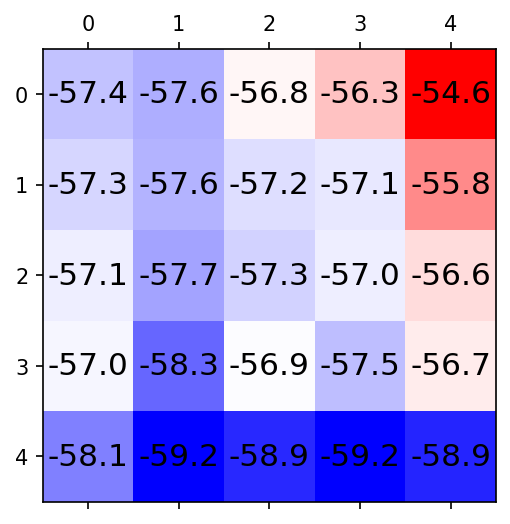

In [34]:
import matplotlib.pyplot as plt
V = calc_value_matrix(q_network, 1, 0, grid_dim_x = 5, grid_dim_y = 5)
plot_value_matrix(V)

In [31]:
def encode(taxi_row, taxi_col, pass_loc, dest_idx):
        # (5) 5, 5, 4
        i = taxi_row
        i *= 5
        i += taxi_col
        i *= 5
        i += pass_loc
        i *= 4
        i += dest_idx
        return i
    
def decode(i):
        out = []
        out.append(i % 4)
        i = i // 4
        out.append(i % 5)
        i = i // 5
        out.append(i % 5)
        i = i // 5
        out.append(i)
        #print(i, 'AAAAAAAAAAAAAAA')
        #assert 0 <= i < 5
        #assert (0 <= i < 5).all
        state_extended = []
        for i in reversed(out):
            state_extended.append(i)
        return state_extended
def calc_value_matrix(Q, PAS_LOC, DEST_LOC, grid_dim_x = 5, grid_dim_y = 5):
    #we fix passenger location and destination location and go inside the environment
    #initialize V
    V = np.zeros((grid_dim_x, grid_dim_y)) + np.inf
    
    #go inside the grid and calculate V
    for t_x in range(grid_dim_x):
        for t_y in range(grid_dim_y):
            state = encode(t_x,t_y, PAS_LOC, DEST_LOC) 
            print(state)
            encoded_obs=recode_states(np.array([state]))
            V[t_x, t_y] = Q(torch.Tensor(encoded_obs).to(device)).max() #np.max(Q[state,:])
    return V

def plot_value_matrix(V):
    fig, ax = plt.subplots(dpi=150)
    #initialize
    for t_x in range(V.shape[0]):
        for t_y in range(V.shape[1]):
            v = V[t_x, t_y]
            ax.text(t_y, t_x, str(round(v, 1)), va='center', ha='center', fontsize=15) 
    ax.matshow(V, cmap='bwr')
    plt.show()

In [14]:
def calc_value_matrix(Q, PAS_LOC, DEST_LOC, grid_dim_x = 5, grid_dim_y = 5):
    #we fix passenger location and destination location and go inside the environment
    #initialize V
    V = np.zeros((grid_dim_x, grid_dim_y)) + np.inf
    
    #go inside the grid and calculate V
    for t_x in range(grid_dim_x):
        for t_y in range(grid_dim_y):
            state = encode(t_x,t_y, PAS_LOC, DEST_LOC) 
            V[t_x, t_y] = np.max(Q[state,:])
    return V

def plot_value_matrix(V):
    fig, ax = plt.subplots(dpi=150)
    #initialize
    for t_x in range(V.shape[0]):
        for t_y in range(V.shape[1]):
            v = V[t_x, t_y]
            ax.text(t_y, t_x, str(round(v, 1)), va='center', ha='center', fontsize=15) 
    ax.matshow(V, cmap='bwr')
    plt.show()